In [253]:
import sqlite3
import pandas as pd
import nltk
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])
    
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\R E K L\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\R E K
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\R E K
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [254]:
con = sqlite3.connect('snatcher/db/nta.db')
df = pd.read_sql_query('SELECT * FROM nta', con)
con.close()
df.head()

,title,content,category,created_date
0,Глеб Никитин и Михаил Мурашко открыли в Нижнем...,Нижний Новгород. 2 января. НТА-Приволжье —Губе...,Общество,2023-01-02
1,Движение возле нижегородского Дворца спорта ог...,Нижний Новгород. 2 января. НТА-Приволжье — Дви...,Городское хозяйство; ЖКХ,2023-01-02
2,Еще один случай нападения на сотрудника скорой...,Саратов. 1 января. НТА-Приволжье — Еще один сл...,Происшествия и криминал,2023-01-01
3,Пожар в доме на улице Бориса Панина тушили 2 я...,Нижний Новгород. 2 января. НТА-Приволжье — Пож...,Происшествия и криминал,2023-01-02
4,"Спектакль ""Человеку нужен человек"" по пьесе Не...",Нижний Новгород. 2 января. НТА-Приволжье — В Н...,Культура и искусство,2023-01-02


# Подготовка данных

In [255]:
data = list(df['content'])
data[:1]

['Нижний Новгород. 2 января. НТА-Приволжье —Губернатор Нижегородской области Глеб Никитин и министр здравоохранения РФ Михаил Мурашко открыли в Нижнем Новгороде памятник "Три врача".Монумент медикам, принимающим участие в борьбе с ковидом, располагается на территории нового корпуса инфекционной больницы № 23. Напомним, закладка памятника состоялась 1 августа 2020 года, в разгар пандемии."Это знак нашего уважения и благодарности за их самоотверженность, ответственность и профессионализм", - отметил глава Нижегородской области.По словам Глеба Никитина, сейчас в госпитале находятся более 240 пациентов (загрузка около 70%). "Грипп, пневмонии, ковид - в новогодние праздники у врачей немало работы. Пожелали коллективу удачи и дальнейшего развития!" - написал в своем телеграм-канале губернатор.По информации пресс-службы нижегородского правительства, затем Михаил Мурашко и Глеб Никитин провели рабочую встречу. Глава региона, в частности, рассказал о ситуации с заболеваемостью гриппом и ОРВИ в 

In [256]:
# Чистим стоп-слова
for text in range(len(data)):
        data[text] = ' '.join([token for token in nltk.word_tokenize(data[text]) if token not in nltk.corpus.stopwords.words('russian')]).replace(' .', '.')
data[1]

'Нижний Новгород. 2 января. НТА-Приволжье — Движение возле нижегородского Дворца спорта ограничат новогодние праздники. Как сообщили городском дептрансе , ограничения будут действовать 3 6 января 07:00 20:00. Объезд возможен прилегающим участкам улично-дорожной сети. Автомобилистов просят учитывать данную информацию планировании поездок. , движение транспорта закроют улице Барнаульской конца февраля 2023 года.'

In [257]:
text = data[3]
doc = Doc(text)
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)
for sentence in doc.sents: # получаем предложения
    try:
        sentence.syntax.print()
    except:
        print()

  ┌► Нижний   amod
┌─└─ Новгород 
└──► .        punct

┌──────────────► НТА-Приволжье nsubj:pass
│           ┌──► —             punct
│           │ ┌► Пожар         amod
│ ┌─────────└─└─ доме          
│ │         └──► улице         nmod
│ │   ┌──────►┌─ Бориса        nmod
│ │   │       └► Панина        flat:name
│ │   │   ┌───┌─ тушили        
│ │   │   │ ┌─└► 2             obl
│ │   │   │ └──► января        flat
│ │ ┌►│   │      .             punct
│ │ │ │   │   ┌► По            case
│ │ │ │ ┌─└►┌─└─ информации    parataxis
│ │ │ │ │   │ ┌► регионального amod
│ │ │ │ │   └►└─ главка        nmod
│ │ │ └─│   └►┌─ МЧС           nmod
│ │ │   │     └► России        nmod
│ │ │   └──────► ,             punct
│ │ │     ┌──►┌─ информация    nsubj:pass
│ │ │     │   └► ЧП            nmod
│ │ │     │   ┌► Советском     amod
│ └►│     │ ┌─└─ районе        nmod
│   │     │ │ ┌► областного    amod
│   │     │ └►└─ центра        nmod
└───└─┌───└───── получена      
      │ ┌►│ ┌─── 07            nu

# Токенизация

In [258]:
tokens_arr = []
for text in data:
    doc = Doc(text)
    doc.segment(segmenter)
    tokens_arr.append(doc)
tokens_arr[1]

Doc(text='Нижний Новгород. 2 января. НТА-Приволжье — Движен..., tokens=[...], sents=[...])

# Лематизация

In [259]:
for doc in tokens_arr:
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

tokens_arr[1].tokens[:5]


[DocToken(stop=6, text='Нижний', pos='ADJ', feats=<Nom,Pos,Masc,Sing>, lemma='нижний'),
 DocToken(start=7, stop=15, text='Новгород', pos='PROPN', feats=<Inan,Nom,Masc,Sing>, lemma='новгород'),
 DocToken(start=15, stop=16, text='.', pos='PUNCT', lemma='.'),
 DocToken(start=17, stop=18, text='2', pos='ADJ', lemma='2'),
 DocToken(start=19, stop=25, text='января', pos='NOUN', feats=<Inan,Gen,Masc,Sing>, lemma='январь')]

# Самые популярные пары подлежащих и сказуемых

In [260]:
popular = {}
for doc in tokens_arr:
    doc.parse_syntax(syntax_parser)
    for sentence in doc.sents:
        root = {}
        nsubj = {}

        for token in sentence.tokens:
            if token.rel == 'root':
                root[token.id] = token.lemma
            if token.rel == 'nsubj':
                nsubj[token.id] = (token.head_id, token.lemma)

        for key, value in nsubj.items():
            try:
               pop = f'{root[value[0]]} + {value[1]}'
               if pop not in popular.keys():
                   popular[pop] = 0
               popular[pop] += 1
            except:
                continue

In [261]:
maximum = []
m = max(popular.values())
for key, value in popular.items():
    if value == m or value == m-1:
        maximum.append(key)
print(maximum)


['сообщить + глава', 'мочь + порыв', 'возможный + случай', 'стать + нта-приволжье', 'произойти + нта-приволжье']


# Самые популярные слова

In [262]:
popularWord = {}
for doc in tokens_arr:
    for token in doc.tokens:
        if token.rel == 'punct':
            continue
        if token.lemma not in popularWord.keys():
            popularWord[token.lemma] = 0
        popularWord[token.lemma] += 1


# Статистика

,Группа,Количество
54,мочь + порыв,4
221,произойти + нта-приволжье,3
55,возможный + случай,3
215,стать + нта-приволжье,3
46,сообщить + глава,3
...,...,...
130,опускаться + день,1
129,характерный + мороз,1
128,отмечать + синоптик,1
127,прогреваться + воздух,1


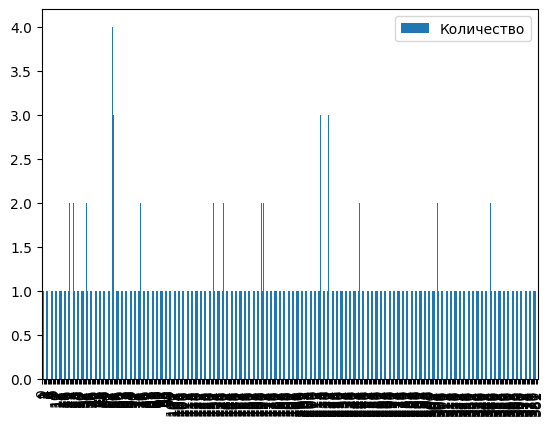

In [279]:
df = pd.DataFrame(popular.items(), columns=['Группа', "Количество"])
display(df.sort_values(by='Количество', ascending=False))
df.plot.bar()
plt.show()

,0,1
3,январь,86
38,год,70
97,в,69
5,нижегородский,51
4,нта-приволжье,50
...,...,...
1264,заражение,1
1262,рекомендация,1
1261,методический,1
1260,дезинфекция,1


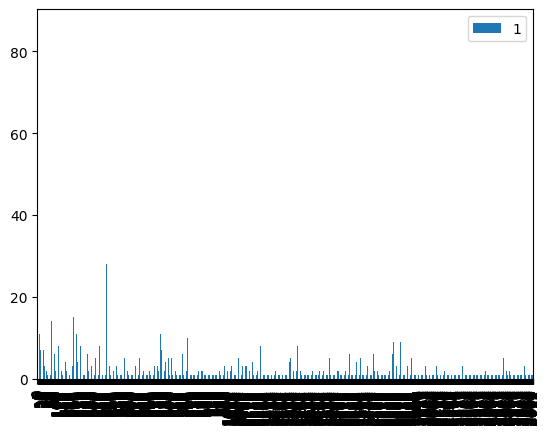

In [280]:
df = pd.DataFrame(popularWord.items())
display(df.sort_values(by=1, ascending=False))
df.plot.bar()
plt.show()

Видим, что слова в основном слова не повторяются. Но при этом самые популярные слова - наименование чего-либо (Дата, город и тд) \
Так же видим, что пары подлежащие и сказуемое вообще не повторяются (за исключением пары случаев)